# GANs for Simple Distribution Generation

The purpose of this notebook is to explore the application of General Adversarial Networks (GANs) in 1D problems.

### i. Imports

In [1]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

## 1. Generating training data

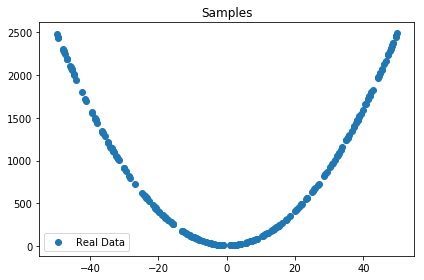

In [2]:
def get_y(x):
    #return 10 + math.e**x
    return 10 + x**2

def sample_data(n=10000, scale=100):
    data = []
    
    x = scale*(np.random.random_sample((n,)) - 0.5)
    
    #x = np.random.random_sample((n,))
    
    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])
        
    return np.array(data)

batch_size = 256
x_plot = sample_data(n=batch_size)
x_ax = plt.scatter(x_plot[:,0], x_plot[:,1], label='Real Data')
plt.legend()
plt.title('Samples')
plt.tight_layout()

## 2. Creating Models
#### Generator

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, use_bias=False, input_shape=(2,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(16, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(2, use_bias=False))
    
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 16)                64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                256       
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 16)                64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

#### Discriminator

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, input_shape=(2,)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())
    
    rep = model.add(layers.Dense(2))
    model.add(layers.Dense(1))
    
    return model, rep

In [5]:
discriminator, rep = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 357
Trainable params: 357
Non-trainable params: 0
________________________________________________________

## 3. Defining loss and optimizers

In [6]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [7]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [8]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [9]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)

## 4. Training

In [10]:
EPOCHS = 1
noise_dim = 2
N_SAMPLES=2560000
BATCH_SIZE=512
TRAIN_STEPS=10

train_dataset = sample_data(n=N_SAMPLES)
train_dataset = np.split(train_dataset, N_SAMPLES/BATCH_SIZE)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch, noise):
    #noise = np.random.uniform(-1., 1., size=[BATCH_SIZE, noise_dim])
    #noise = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, noise_dim])
    #noise = tf.random.uniform([BATCH_SIZE, noise_dim])
    #noise = tf.random.normal(shape=[BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_batch = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_batch, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss

In [13]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    #for sample_batch in dataset: #10000
    #    for step in range(TRAIN_STEPS):
    #        disc_loss, gen_loss = train_step(sample_batch)
    for i in range(10001):
        iter_start = time.time()
        sample_batch = sample_data(n=BATCH_SIZE)
        noise = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, noise_dim])
        #noise = tf.random.normal([BATCH_SIZE, noise_dim])
        
        for step in range(TRAIN_STEPS):
            disc_loss, gen_loss = train_step(sample_batch, noise)
            
        if (i + 1) % 1000 == 0:
            print('Time for iteration {} is {} sec'.format(i + 1, time.time()-iter_start))
            print("Discriminator loss: {0:.4f}\t Generator loss: {0:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("Discriminator loss: {0:.4f}\t Generator loss: {0:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))

In [14]:
%%time
train(train_dataset, EPOCHS)

Time for iteration 1000 is 0.011427879333496094 sec
Discriminator loss: 1.3864	 Generator loss: 1.3864

Time for iteration 2000 is 0.010713577270507812 sec
Discriminator loss: 1.3808	 Generator loss: 1.3808

Time for iteration 3000 is 0.01029515266418457 sec
Discriminator loss: 1.3764	 Generator loss: 1.3764

Time for iteration 4000 is 0.01123189926147461 sec
Discriminator loss: 1.3530	 Generator loss: 1.3530

Time for iteration 5000 is 0.011590957641601562 sec
Discriminator loss: 1.3610	 Generator loss: 1.3610

Time for iteration 6000 is 0.011473655700683594 sec
Discriminator loss: 1.3776	 Generator loss: 1.3776

Time for iteration 7000 is 0.011227607727050781 sec
Discriminator loss: 1.2833	 Generator loss: 1.2833

Time for iteration 8000 is 0.011622428894042969 sec
Discriminator loss: 1.2531	 Generator loss: 1.2531

Time for iteration 9000 is 0.011207342147827148 sec
Discriminator loss: 1.3923	 Generator loss: 1.3923

Time for iteration 10000 is 0.010796070098876953 sec
Discriminator

In [15]:
def plot_examples(real, generated):
    r_ax = plt.scatter(real[:,0], real[:,1], label='Real Data')
    g_ax = plt.scatter(generated[:,0], generated[:,1], label='Generated Data', color='orange')
    plt.legend()
    plt.title('Samples')
    plt.tight_layout()

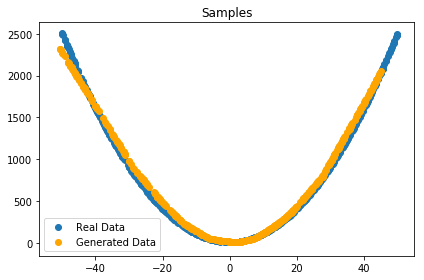

In [16]:
num_examples = 512
#seed = tf.random.normal([num_examples, noise_dim])
seed = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, noise_dim])
pred = generator(seed, training=False)
samples = sample_data(n=BATCH_SIZE)

plot_examples(samples, pred)

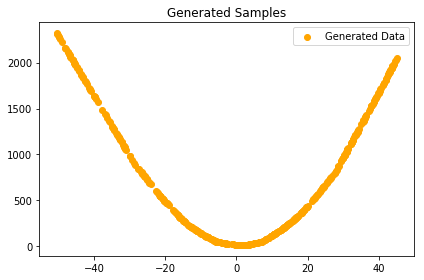

In [17]:
def plot_gen(generated):
    g_ax = plt.scatter(generated[:,0], generated[:,1], label='Generated Data', color='orange')
    plt.legend()
    plt.title('Generated Samples')
    plt.tight_layout()
    
plot_gen(pred)